In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")

print("Train Data Head:")
print(train_data.head())

Train Data Head:
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   

In [3]:
# Name에서 title(호칭) 추출하기
# 예: "Braund, Mr. Owen Harris" -> "Mr"
# train_data와 test_data에 모두 적용해야 합니다.
for dataset in [train_data, test_data]:
    dataset['title'] = dataset['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

# 흔하지 않은 title은 'other'로 통합
# pd.crosstab(train_data['title'], train_data['Sex']) # title 종류 확인
for dataset in [train_data, test_data]:
    dataset['title'] = dataset['title'].replace(['Lady', 'Countess','Capt', 'Col', \
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'other')
    dataset['title'] = dataset['title'].replace('Mlle', 'Miss')
    dataset['title'] = dataset['title'].replace('Ms', 'Miss')
    dataset['title'] = dataset['title'].replace('Mme', 'Mrs')

# title을 숫자로 매핑 (0=Mr, 1=Miss, 2=Mrs, 3=Master, 4=other)
title_mapping = {"Mr": 0, "Miss": 1, "Mrs": 2, "Master": 3, "other": 4}
for dataset in [train_data, test_data]:
    dataset['title'] = dataset['title'].map(title_mapping)
    # 혹시 모를 결측치는 0으로 채움
    dataset['title'] = dataset['title'].fillna(0)


# family_num (가족 총 인원) 생성 = SibSp + Parch
for dataset in [train_data, test_data]:
    dataset['family_num'] = dataset['SibSp'] + dataset['Parch']

# alone (혼자인지 여부) 생성
for dataset in [train_data, test_data]:
    dataset['alone'] = 0 # 기본값은 0 (가족과 함께)
    dataset.loc[dataset['family_num'] == 0, 'alone'] = 1 # family_num이 0이면 1 (혼자)

In [4]:
# Age 결측치: 전체 승객의 나이 평균 또는 중위값으로 채우기 (중위값이 이상치에 더 강건)
# train_data의 중위값으로 train/test 데이터 모두 채워주는 것이 중요합니다.
age_median = train_data['Age'].median()
for dataset in [train_data, test_data]:
    dataset['Age'].fillna(age_median)

# Embarked 결측치: 가장 많이 탑승한 항구(최빈값)로 채우기
# train_data에서 최빈값을 찾아 train/test 데이터에 적용
embarked_mode = train_data['Embarked'].mode()[0]
for dataset in [train_data, test_data]:
    dataset['Embarked'].fillna(embarked_mode)

# Fare 결측치 (test_data에만 존재할 수 있음)
# train_data의 요금 중위값으로 채우기
fare_median = train_data['Fare'].median()
test_data['Fare'].fillna(fare_median)

0        7.8292
1        7.0000
2        9.6875
3        8.6625
4       12.2875
         ...   
413      8.0500
414    108.9000
415      7.2500
416      8.0500
417     22.3583
Name: Fare, Length: 418, dtype: float64

In [5]:
# Sex (성별) 수치화 (male=0, female=1)
sex_mapping = {'male': 0, 'female': 1}
# 결측치를 채우기 위해 가장 흔한 성별(mode)의 매핑된 값을 미리 찾아둡니다.
sex_mode = train_data['Sex'].mode()[0]       # 아마 'male'이 나올 것입니다.
sex_mode_mapped = sex_mapping[sex_mode]  # 'male'이면 0이 됩니다.

for dataset in [train_data, test_data]:
    # 1. map을 이용해 숫자로 변환합니다. (결측치는 여기서 NaN이 됩니다)
    dataset['Sex'] = dataset['Sex'].map(sex_mapping)
    
    # 2. NaN 값을 가장 흔한 성별의 숫자(0)로 채웁니다.
    dataset['Sex'] = dataset['Sex'].fillna(sex_mode_mapped)
    
    # 3. NaN이 모두 채워졌으므로 안전하게 정수로 변환합니다.
    dataset['Sex'] = dataset['Sex'].astype(int)


# Embarked (탑승지) 수치화 (C=0, Q=1, S=2)
embarked_mapping = {'C': 0, 'Q': 1, 'S': 2}
# 결측치를 채우기 위해 가장 흔한 탑승지(mode)의 매핑된 값을 미리 찾아둡니다.
embarked_mode = train_data['Embarked'].mode()[0]      # 'S'가 나올 것입니다.
embarked_mode_mapped = embarked_mapping[embarked_mode] # 'S'이므로 2가 됩니다.

for dataset in [train_data, test_data]:
    # 1. map을 이용해 숫자로 변환합니다.
    dataset['Embarked'] = dataset['Embarked'].map(embarked_mapping)
    
    # 2. NaN 값을 가장 흔한 탑승지의 숫자(2)로 채웁니다.
    dataset['Embarked'] = dataset['Embarked'].fillna(embarked_mode_mapped)
    
    # 3. 안전하게 정수로 변환합니다.
    dataset['Embarked'] = dataset['Embarked'].astype(int)

print("Sex, Embarked 전처리 완료.")

Sex, Embarked 전처리 완료.


In [6]:
# PassengerId는 단순 식별자, Name은 title 추출에 사용, Ticket은 너무 고유값이 많음
# Cabin은 결측치가 너무 많음
drop_features = ['PassengerId', 'Name', 'Ticket', 'Cabin']
train_data = train_data.drop(drop_features, axis=1)
# test_data에는 'Survived' 컬럼이 없으므로, 이를 제외한 리스트를 만들어야 함
# 하지만 test_data에는 PassengerId가 필요할 수 있으니 남겨두고 나머지만 지우는 경우도 많음
# 여기서는 제출 파일을 만들기 위해 test_passenger_id를 저장해두고 지웁니다.
test_passenger_id = test_data['PassengerId']
test_data = test_data.drop(drop_features, axis=1)

print("--- 전처리 후 데이터 샘플 ---")
print(train_data.head())

--- 전처리 후 데이터 샘플 ---
   Survived  Pclass  Sex   Age  SibSp  Parch     Fare  Embarked  title  \
0         0       3    0  22.0      1      0   7.2500         2      0   
1         1       1    1  38.0      1      0  71.2833         0      2   
2         1       3    1  26.0      0      0   7.9250         2      1   
3         1       1    1  35.0      1      0  53.1000         2      2   
4         0       3    0  35.0      0      0   8.0500         2      0   

   family_num  alone  
0           1      0  
1           1      0  
2           0      1  
3           1      0  
4           0      1  


In [7]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, random_split
# 출력 폭 제한을 해제 (무제한)
pd.set_option("display.width", None)
# 모든 컬럼 출력되도록 설정
pd.set_option("display.max_columns", None)

class TitanicDataset(Dataset):
  def __init__(self, X, y):
    self.X = torch.FloatTensor(X)
    self.y = torch.LongTensor(y)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    feature = self.X[idx]
    target = self.y[idx]
    return {'input': feature, 'target': target}

  def __str__(self):
    str = "Data Size: {0}, Input Shape: {1}, Target Shape: {2}".format(
      len(self.X), self.X.shape, self.y.shape
    )
    return str


class TitanicTestDataset(Dataset):
  def __init__(self, X):
    self.X = torch.FloatTensor(X)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    feature = self.X[idx]
    return {'input': feature}

  def __str__(self):
    str = "Data Size: {0}, Input Shape: {1}".format(
      len(self.X), self.X.shape
    )
    return str


def get_preprocessed_dataset():
    train_data_path = "/kaggle/input/titanic/train.csv"
    test_data_path = "/kaggle/input/titanic/test.csv"

    train_df = pd.read_csv(train_data_path)
    test_df = pd.read_csv(test_data_path)

    all_df = pd.concat([train_df, test_df], sort=False)

    all_df = get_preprocessed_dataset_1(all_df)

    all_df = get_preprocessed_dataset_2(all_df)

    all_df = get_preprocessed_dataset_3(all_df)

    all_df = get_preprocessed_dataset_4(all_df)

    all_df = get_preprocessed_dataset_5(all_df)

    all_df = get_preprocessed_dataset_6(all_df)

    print(all_df.columns)
    print(all_df.head(10))

    train_X = all_df[~all_df["Survived"].isnull()].drop("Survived", axis=1).reset_index(drop=True)
    train_y = train_df["Survived"]

    test_X = all_df[all_df["Survived"].isnull()].drop("Survived", axis=1).reset_index(drop=True)
    dataset = TitanicDataset(train_X.values, train_y.values)
    print(dataset)

    train_dataset, validation_dataset = random_split(dataset, [0.8, 0.2])
    test_dataset = TitanicTestDataset(test_X.values)
    #print(test_dataset)

    return train_dataset, validation_dataset, test_dataset


def get_preprocessed_dataset_1(all_df):
    # Pclass별 Fare (요금) 평균값을 사용하여 Fare 결측치 메우기
    Fare_mean = all_df[["Pclass", "Fare"]].groupby("Pclass").mean().reset_index()
    Fare_mean.columns = ["Pclass", "Fare_mean"]
    all_df = pd.merge(all_df, Fare_mean, on="Pclass", how="left")
    all_df.loc[(all_df["Fare"].isnull()), "Fare"] = all_df["Fare_mean"]
    all_df = all_df.drop(columns=["Fare_mean"])

    return all_df


def get_preprocessed_dataset_2(all_df):
    # name을 세 개의 컬럼으로 분리하여 다시 all_df에 합침
    name_df = all_df["Name"].str.split("[,.]", n=2, expand=True)
    name_df.columns = ["family_name", "title", "name"]
    name_df["family_name"] = name_df["family_name"].str.strip()
    name_df["title"] = name_df["title"].str.strip()
    name_df["name"] = name_df["name"].str.strip()
    all_df = pd.concat([all_df, name_df], axis=1)

    return all_df


def get_preprocessed_dataset_3(all_df):
    # title별 Age 평균값을 사용하여 Age 결측치 메우기
    title_age_mean = all_df[["title", "Age"]].groupby("title").median().round().reset_index()
    title_age_mean.columns = ["title", "title_age_mean", ]
    all_df = pd.merge(all_df, title_age_mean, on="title", how="left")
    all_df.loc[(all_df["Age"].isnull()), "Age"] = all_df["title_age_mean"]
    all_df = all_df.drop(["title_age_mean"], axis=1)

    return all_df


def get_preprocessed_dataset_4(all_df):
    # 가족수(family_num) 컬럼 새롭게 추가
    all_df["family_num"] = all_df["Parch"] + all_df["SibSp"]

    # 혼자탑승(alone) 컬럼 새롭게 추가
    all_df.loc[all_df["family_num"] == 0, "alone"] = 1
    all_df["alone"] = all_df["alone"].fillna(0)

    # 학습에 불필요한 컬럼 제거
    all_df = all_df.drop(["PassengerId", "Name", "family_name", "name", "Ticket", "Cabin"], axis=1)

    return all_df


def get_preprocessed_dataset_5(all_df):
    # title 값 개수 줄이기
    all_df.loc[
    ~(
            (all_df["title"] == "Mr") |
            (all_df["title"] == "Miss") |
            (all_df["title"] == "Mrs") |
            (all_df["title"] == "Master")
    ),
    "title"
    ] = "other"
    all_df["Embarked"] = all_df["Embarked"].fillna("missing")
    
    return all_df


def get_preprocessed_dataset_6(all_df):
    # 카테고리 변수를 LabelEncoder를 사용하여 수치값으로 변경하기
    category_features = all_df.columns[all_df.dtypes == "object"]
    from sklearn.preprocessing import LabelEncoder
    for category_feature in category_features:
        le = LabelEncoder()
        if all_df[category_feature].dtypes == "object":
          le = le.fit(all_df[category_feature])
          all_df[category_feature] = le.transform(all_df[category_feature])

    return all_df


if __name__ == "__main__":
  train_dataset, validation_dataset, test_dataset = get_preprocessed_dataset()

  print("train_dataset: {0}, validation_dataset.shape: {1}, test_dataset: {2}".format(
    len(train_dataset), len(validation_dataset), len(test_dataset)
  ))
  print("#" * 50, 1)

  train_data_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
  validation_data_loader = DataLoader(dataset=validation_dataset, batch_size=len(validation_dataset), shuffle=True)
  test_data_loader = DataLoader(dataset=test_dataset, batch_size=len(test_dataset))

  print("[TRAIN]")
  for idx, batch in enumerate(train_data_loader):
    print("{0} - {1}: {2}".format(idx, batch['input'].shape, batch['target'].shape))

  print("[VALIDATION]")
  for idx, batch in enumerate(validation_data_loader):
    print("{0} - {1}: {2}".format(idx, batch['input'].shape, batch['target'].shape))

  print("[TEST]")
  for idx, batch in enumerate(test_data_loader):
    print("{0} - {1}".format(idx, batch['input'].shape))


Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked', 'title', 'family_num', 'alone'],
      dtype='object')
   Survived  Pclass  Sex   Age  SibSp  Parch     Fare  Embarked  title  \
0       0.0       3    1  22.0      1      0   7.2500         2      2   
1       1.0       1    0  38.0      1      0  71.2833         0      3   
2       1.0       3    0  26.0      0      0   7.9250         2      1   
3       1.0       1    0  35.0      1      0  53.1000         2      3   
4       0.0       3    1  35.0      0      0   8.0500         2      2   
5       0.0       3    1  29.0      0      0   8.4583         1      2   
6       0.0       1    1  54.0      0      0  51.8625         2      2   
7       0.0       3    1   2.0      3      1  21.0750         2      0   
8       1.0       3    0  27.0      0      2  11.1333         2      3   
9       1.0       2    0  14.0      1      0  30.0708         0      3   

   family_num  alone  
0           1    0.

In [8]:
pip install wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.9/19.9 MB 125.6 MB/s eta 0:00:00

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [9]:
# 요구사항 1
import os
os.environ["WANDB_DISABLE_SYSTEM_METRICS"] = "true"
import pandas as pd
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
import copy # 모델의 state_dict를 깊은 복사하기 위해 import
import sys
import random

# Weights & Biases for experiment tracking
import wandb
#재현성을 위한 시드 고정 함수
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# 시드 고정 실행
set_seed(12)

/usr/local/lib/python3.12/site-packages/pydantic/_internal/_generate_schema.py:2262: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/site-packages/pydantic/_internal/_generate_schema.py:2262: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [10]:

# --- 기본 설정 ---
# W&B 사용 여부
USE_WANDB = True

# --- 데이터 경로 ---
DATA_PATH = "/kaggle/input/titanic/"
TRAIN_CSV_PATH = os.path.join(DATA_PATH, "train.csv")
TEST_CSV_PATH = os.path.join(DATA_PATH, "test.csv")

#---------------------------
# 요구사항 2
#---------------------------
# --- 활성화 함수 매핑 ---
ACTIVATION_FUNCTIONS = {
    #"ReLU": nn.ReLU,
    #"Sigmoid": nn.Sigmoid,
    #"ELU": nn.ELU,
    "LeakyReLU": nn.LeakyReLU
}
#---------------------------
# 요구사항 2
#---------------------------
# --- 하이퍼파라미터 ---
CONFIG = {
    'epochs': 1000,
    'batch_size': 64,      # 실험 대상: 16, 32, 64, 128
    'learning_rate': 1e-4,
    'n_hidden_unit_list': [20, 20],
    'activation': 'ELU',  # 실험 대상: 'ReLU', 'Sigmoid', 'ELU', 'LeakyReLU'
}

In [11]:
# 요구사항 1
def get_preprocessed_dataset_1(all_df):
    Fare_mean = all_df[["Pclass", "Fare"]].groupby("Pclass").mean().reset_index()
    Fare_mean.columns = ["Pclass", "Fare_mean"]
    all_df = pd.merge(all_df, Fare_mean, on="Pclass", how="left")
    all_df.loc[(all_df["Fare"].isnull()), "Fare"] = all_df["Fare_mean"]
    all_df = all_df.drop(columns=["Fare_mean"])
    return all_df

def get_preprocessed_dataset_2(all_df):
    name_df = all_df["Name"].str.split("[,.]", n=2, expand=True)
    name_df.columns = ["family_name", "title", "name"]
    name_df["family_name"] = name_df["family_name"].str.strip()
    name_df["title"] = name_df["title"].str.strip()
    name_df["name"] = name_df["name"].str.strip()
    all_df = pd.concat([all_df, name_df], axis=1)
    return all_df

def get_preprocessed_dataset_3(all_df):
    title_age_median = all_df[["title", "Age"]].groupby("title").median().round().reset_index()
    title_age_median.columns = ["title", "title_age_median"]
    all_df = pd.merge(all_df, title_age_median, on="title", how="left")
    all_df.loc[(all_df["Age"].isnull()), "Age"] = all_df["title_age_median"]
    all_df = all_df.drop(["title_age_median"], axis=1)
    return all_df

def get_preprocessed_dataset_4(all_df):
    all_df["family_num"] = all_df["Parch"] + all_df["SibSp"]
    all_df.loc[all_df["family_num"] == 0, "alone"] = 1
    all_df["alone"] = all_df["alone"].fillna(0)
    all_df = all_df.drop(["PassengerId", "Name", "family_name", "name", "Ticket", "Cabin"], axis=1)
    return all_df

def get_preprocessed_dataset_5(all_df):
    all_df.loc[
        ~((all_df["title"] == "Mr") | (all_df["title"] == "Miss") | (all_df["title"] == "Mrs") | (all_df["title"] == "Master")),
        "title"
    ] = "other"
    embarked_mode = all_df['Embarked'].mode()[0]
    all_df["Embarked"] = all_df["Embarked"].fillna(embarked_mode)
    return all_df

def get_preprocessed_dataset_6(all_df):
    category_features = all_df.columns[all_df.dtypes == "object"]
    for category_feature in category_features:
        le = LabelEncoder()
        if all_df[category_feature].dtypes == "object":
            le = le.fit(all_df[category_feature])
            all_df[category_feature] = le.transform(all_df[category_feature])
    return all_df

In [12]:
# 요구사항 1
train_df = pd.read_csv(TRAIN_CSV_PATH)
test_df = pd.read_csv(TEST_CSV_PATH)
submission_df = pd.read_csv(os.path.join(DATA_PATH, "gender_submission.csv"))
all_df = pd.concat([train_df, test_df], sort=False)
all_df = get_preprocessed_dataset_1(all_df)
all_df = get_preprocessed_dataset_2(all_df)
all_df = get_preprocessed_dataset_3(all_df)
all_df = get_preprocessed_dataset_4(all_df)
all_df = get_preprocessed_dataset_5(all_df)
all_df = get_preprocessed_dataset_6(all_df)
train_X = all_df[~all_df["Survived"].isnull()].drop("Survived", axis=1).reset_index(drop=True)
train_y = train_df["Survived"]
test_X = all_df[all_df["Survived"].isnull()].drop("Survived", axis=1).reset_index(drop=True)

In [13]:
# 요구사항 1
class TitanicDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return {'input': self.X[idx], 'target': self.y[idx]}

class TitanicTestDataset(Dataset):
    def __init__(self, X):
        self.X = torch.FloatTensor(X)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return {'input': self.X[idx]}

full_dataset = TitanicDataset(train_X.values, train_y.values)
train_size = int(0.8 * len(full_dataset))
validation_size = len(full_dataset) - train_size
train_dataset, validation_dataset = random_split(full_dataset, [train_size, validation_size])
test_dataset = TitanicTestDataset(test_X.values)
train_data_loader = DataLoader(dataset=train_dataset, batch_size=CONFIG['batch_size'], shuffle=True)
validation_data_loader = DataLoader(dataset=validation_dataset, batch_size=len(validation_dataset))
test_data_loader = DataLoader(dataset=test_dataset, batch_size=len(test_dataset))


In [14]:
# 요구사항 1
class MyModel(nn.Module):
    def __init__(self, n_input, n_output, activation_fn):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(n_input, CONFIG['n_hidden_unit_list'][0]),
            activation_fn(),
            nn.Linear(CONFIG['n_hidden_unit_list'][0], CONFIG['n_hidden_unit_list'][1]),
            activation_fn(),
            nn.Linear(CONFIG['n_hidden_unit_list'][1], n_output),
        )
    def forward(self, x):
        return self.model(x)

In [15]:
# 요구사항 1
def training_loop(model, optimizer, train_loader, val_loader, loss_fn, epochs, device):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # 가장 좋았던 시점의 성능과 모델 상태를 저장할 변수
    best_accuracy = 0.0
    best_model_state = None
    best_epoch = 0

    for epoch in range(1, epochs + 1):
        model.train()
        train_loss = 0.0
        for batch in train_loader:
            inputs, targets = batch['input'].to(device), batch['target'].to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs.squeeze(), targets.float())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        val_loss = 0.0
        correct_preds = 0
        total_samples = 0
        with torch.no_grad():
            for batch in val_loader:
                inputs, targets = batch['input'].to(device), batch['target'].to(device)
                outputs = model(inputs)
                loss = loss_fn(outputs.squeeze(), targets.float())
                val_loss += loss.item()
                preds = torch.sigmoid(outputs.squeeze()) > 0.5
                total_samples += targets.size(0)
                correct_preds += (preds == targets.bool()).sum().item()

        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        accuracy = correct_preds / total_samples

        # --- 모델 체크포인팅 로직 ---
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model_state = copy.deepcopy(model.state_dict())
            best_epoch = epoch

        if USE_WANDB:
            wandb.log({
                "Epoch": epoch,
                "Training loss": avg_train_loss,
                "Validation loss": avg_val_loss,
                "Accuracy": accuracy
            })
        
        if epoch % 100 == 0 or epoch == epochs:
            print(f"Epoch {epoch}/{epochs}, Acc: {accuracy:.4f} (Best Acc: {best_accuracy:.4f}), Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
            sys.stdout.flush()
    print(f"\nTraining finished. Best validation accuracy: {best_accuracy:.4f}")
    return best_model_state, best_accuracy, best_epoch

In [16]:
# 요구사항 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

#모든 실험을 통틀어 최고의 모델을 저장할 변수
overall_best_accuracy = 0.0
overall_best_model_state = None
best_experiment_name = ""
overall_best_epoch = 0 

# 4가지 활성화 함수를 순회하며 각각 독립적인 훈련을 진행
for act_name, act_class in ACTIVATION_FUNCTIONS.items():
    
    CONFIG['activation'] = act_name
    exp_name = f"batch_{CONFIG['batch_size']}_act_{act_name}"
    
    print("\n" + "="*60)
    print(f"--- Starting Experiment: {exp_name} ---")
    print("="*60)

    if USE_WANDB:
        try:
            wandb.init(
                project="HW_Titanic_final",
                config=CONFIG,
                name=exp_name,
                reinit=True # 루프 내에서 init을 여러 번 호출하려면 True로 설정
            )
        except:
            print("W&B 초기화 실패.")
            wandb.init(mode="disabled")

    # 각 실험마다 모델과 옵티마이저를 새로 초기화
    model = MyModel(
        n_input=train_X.shape[1],
        n_output=1,
        activation_fn=act_class
    )
    optimizer = optim.Adam(model.parameters(), lr=CONFIG['learning_rate'])
    loss_fn = nn.BCEWithLogitsLoss()

    # 현재 실험의 최고 모델 상태를 반환받음
    current_best_model_state, current_accuracy, current_best_epoch = training_loop(
        model=model, optimizer=optimizer,
        train_loader=train_data_loader, val_loader=validation_data_loader,
        loss_fn=loss_fn, epochs=CONFIG['epochs'], device=device
    )
    
    #현재 실험의 최고 정확도를 가져오기 위해 모델 상태를 잠시 로드하여 평가
    temp_model = MyModel(n_input=train_X.shape[1], n_output=1, activation_fn=act_class).to(device)
    if current_best_model_state:
        temp_model.load_state_dict(current_best_model_state)
    temp_model.eval()
    correct_preds, total_samples = 0, 0
    with torch.no_grad():
        for batch in validation_data_loader:
            inputs, targets = batch['input'].to(device), batch['target'].to(device)
            outputs = temp_model(inputs)
            preds = torch.sigmoid(outputs.squeeze()) > 0.5
            total_samples += targets.size(0)
            correct_preds += (preds == targets.bool()).sum().item()
    current_accuracy = correct_preds / total_samples

    #전체 최고 기록과 비교하여 업데이트
    if current_accuracy > overall_best_accuracy:
        print(f"New Overall Best Model Found in '{exp_name}' with Accuracy: {current_accuracy:.4f}")
        overall_best_accuracy = current_accuracy
        overall_best_model_state = current_best_model_state
        best_experiment_name = exp_name
        overall_best_epoch = current_best_epoch
        
    if USE_WANDB:
        wandb.finish()


Using device: cpu

--- Starting Experiment: batch_64_act_LeakyReLU ---


wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

  ········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: dldmsgh5280 (dldmsgh5280-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


Epoch 100/1000, Acc: 0.6927 (Best Acc: 0.7039), Train Loss: 0.5859, Val Loss: 0.6257
Epoch 200/1000, Acc: 0.6760 (Best Acc: 0.7039), Train Loss: 0.5691, Val Loss: 0.6024
Epoch 300/1000, Acc: 0.6592 (Best Acc: 0.7039), Train Loss: 0.5650, Val Loss: 0.5720
Epoch 400/1000, Acc: 0.6983 (Best Acc: 0.7039), Train Loss: 0.5052, Val Loss: 0.5311
Epoch 500/1000, Acc: 0.7486 (Best Acc: 0.7765), Train Loss: 0.4950, Val Loss: 0.4874
Epoch 600/1000, Acc: 0.8101 (Best Acc: 0.8268), Train Loss: 0.4656, Val Loss: 0.4561
Epoch 700/1000, Acc: 0.8324 (Best Acc: 0.8324), Train Loss: 0.4418, Val Loss: 0.4340
Epoch 800/1000, Acc: 0.8212 (Best Acc: 0.8324), Train Loss: 0.4584, Val Loss: 0.4226
Epoch 900/1000, Acc: 0.8324 (Best Acc: 0.8492), Train Loss: 0.4435, Val Loss: 0.4137
Epoch 1000/1000, Acc: 0.8324 (Best Acc: 0.8547), Train Loss: 0.4342, Val Loss: 0.4092

Training finished. Best validation accuracy: 0.8547
New Overall Best Model Found in 'batch_64_act_LeakyReLU' with Accuracy: 0.8547


Accuracy,▁▁▁▂▂▃▃▄▄▄▃▃▃▃▃▃▃▄▄▅▅▅▆▆▆▇▇▇▇▇▇█▇▇██████
Epoch,▁▁▁▁▁▁▂▂▂▂▂▂▂▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇█
Training loss,█▆▆▆▆▅▅▆▅▅▄▅▄▅▅▃▃▃▂▃▂▂▂▁▁▂▂▁▂▁▃▂▂▁▁▁▁▁▁▁
Validation loss,█▇▅▄▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Accuracy,0.8324
Epoch,1000
Training loss,0.43415
Validation loss,0.40915


In [17]:
print(f"\nAll experiments finished. The best model was from '{best_experiment_name}' at epoch {overall_best_epoch} with accuracy {overall_best_accuracy:.4f}.")

# 최종적으로 가장 좋았던 모델의 파라미터를 다시 불러옴
# 모델 구조를 다시 정의해야 함 (최고 모델의 활성화 함수로)
best_act_name = best_experiment_name.split('_act_')[-1]
best_act_fn = ACTIVATION_FUNCTIONS[best_act_name]
final_model = MyModel(n_input=train_X.shape[1], n_output=1, activation_fn=best_act_fn).to(device)

if overall_best_model_state:
    final_model.load_state_dict(overall_best_model_state)
    print("\nOverall best model loaded for submission.")
else:
    print("\nNo best model was saved.")
#---------------------------
# 요구사항 3
#---------------------------

final_model.eval()
predictions = []
with torch.no_grad():
    for batch in test_data_loader:
        inputs = batch['input'].to(device)
        outputs = final_model(inputs) # final_model로 예측
        preds = (torch.sigmoid(outputs.squeeze()) > 0.5).int()
        if preds.ndim == 0:
            preds = preds.unsqueeze(0)
        predictions.extend(preds.cpu().numpy())

submission_df['Survived'] = predictions
submission_df.to_csv('submission.csv', index=False)

print("\n'submission.csv' 파일이 생성되었습니다.")
print(submission_df.head())


All experiments finished. The best model was from 'batch_64_act_LeakyReLU' at epoch 975 with accuracy 0.8547.

Overall best model loaded for submission.

'submission.csv' 파일이 생성되었습니다.
   PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         1


### 요구사항 4

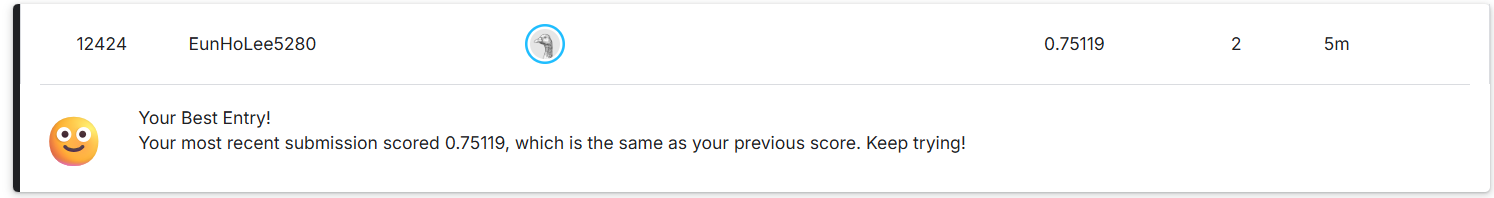